### Домашнее задание №12 по теме «Алгоритмы кластеризации» 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import cv2
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from skimage.metrics import structural_similarity as ssim

#### Задание  
__Цель:__  
Изучить применение моделей кластеризации  
__Описание задания:__  
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве `RGB`, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.
__Этапы работы:__

1. Получите данные и загрузите их в рабочую среду.  
    a. Для отображения картинки воспользуйтесь вспомогательной функцией:  
        import matplotlib.pyplot as plt
        import cv2
        import skimage
        def draw_picture(image, title, bgr=False):
            b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
            new_image = cv2.merge([r, g, b])
            plt.figure(figsize=(7, 5))
            plt.axis(‘off’)
            plt.imshow(new_image)
            plt.title(title)
            plt.show()
    b. Для загрузки картинки можно использовать код:  
        img = cv2.imread(path)
2. Реализуйте три модели кластеризации:  
    a. `KMeans`. Рассмотрите число кластеров K = 2, 5, 10, 20.  
    b. `DBSCAN`  
    c. `AgglomerativeClustering`. Рассмотрите число кластеров K = 2, 5, 10, 20.  
3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики `SSIM`.
4. Сформулируйте выводы по проделанной работе.    
    a. Какая модель показала лучший результат?  
_____
Для получения зачета по этому домашнему заданию минимально должно быть реализовано обучение трех моделей с одним и тем же значением кластеров, где такой параметр присутствует.

#### 1. Загружаем картинку

In [2]:
path = 'Downloads/птица.jpeg'

In [3]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title, fontsize=8)

In [4]:
img = cv2.imread(path)
img = cv2.resize(img, (200, 200))

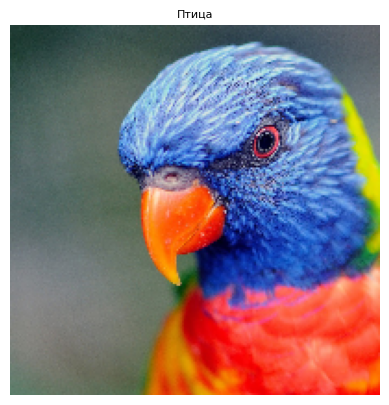

In [5]:
draw_picture(img, 'Птица', bgr=False)

In [6]:
img.shape

(200, 200, 3)

In [7]:
img

array([[[ 56,  63,  36],
        [ 56,  63,  36],
        [ 53,  60,  33],
        ...,
        [106,  99,  96],
        [110, 103, 100],
        [105,  98,  95]],

       [[ 54,  61,  34],
        [ 52,  59,  32],
        [ 51,  58,  31],
        ...,
        [103,  99,  96],
        [103,  98,  95],
        [104,  99,  96]],

       [[ 51,  58,  31],
        [ 53,  60,  33],
        [ 55,  62,  35],
        ...,
        [105, 100,  97],
        [103,  98,  95],
        [108, 101,  98]],

       ...,

       [[107, 126,  93],
        [107, 125,  94],
        [106, 124,  94],
        ...,
        [ 10,  36, 252],
        [  1,  27, 248],
        [  5,  24, 253]],

       [[107, 126,  93],
        [106, 125,  92],
        [104, 122,  91],
        ...,
        [  1,  12, 250],
        [  4,  14, 253],
        [  5,  13, 253]],

       [[101, 124,  86],
        [108, 127,  93],
        [108, 127,  94],
        ...,
        [  3,   2, 252],
        [  5,   5, 253],
        [  1,   3, 251]]

Объект `img` это 3D матрица где измерения это высота, ширина и количество каналов цвета. Преобразуем ее в двухмерную, где канал будет определен для каждого пикселя

In [8]:
X = img.reshape(img.shape[0] * img.shape[1], 3)
X

array([[ 56,  63,  36],
       [ 56,  63,  36],
       [ 53,  60,  33],
       ...,
       [  3,   2, 252],
       [  5,   5, 253],
       [  1,   3, 251]], dtype=uint8)

In [9]:
X.shape

(40000, 3)

#### 2. Реализация моделей кластеризации

Далее для уменьшения количества цветов соберем функцию где:  
1. Изменим размерность исходного изображения
2. Создадим объект модели в указанием параметра количества кластеров (для DBSCAN кластера не выбираются - этот объект будет создаваться в отдельной ветке
3. Если какой-то параметр будет приводить к ошибке выведем оригинальную матрицу
4. Получим вектор с кластерами
5. Преобразуем 2D матрицу в пандасовский  датафрейм
6. Добавим вектор с кластерами к датафрейму
7. Создадим словарь где ключи это идентификаторы кластеров, а значения средние значения трех каналов
8. Заменим каждую строку в 2D матрице на полученные усредненные значения канала в соответствии с кластером
9. Преобразуем 2D матрицу снова в 3D
10. Рассчитаем метрику SSIM и отрисуем изображение

In [10]:
def get_image(img, model, n_clusters=2):
    X = img.reshape(img.shape[0] * img.shape[1], 3)
    try:
        if model == DBSCAN:
            m = DBSCAN(eps=4, min_samples=2)
        else:
            m = model(n_clusters=n_clusters)        
        cluster = m.fit_predict(X)
        df = pd.DataFrame(X)
        df['cluster'] = cluster

        cluster_dict = {c: df.loc[df['cluster'] == c, [0, 1, 2]].mean(axis=0) for c in set(cluster)}

        X_mod = [cluster_dict[c] for c in cluster]
        X_mod = np.array(X_mod, dtype=np.uint8)
        img_mod = X_mod.reshape(img.shape[0], img.shape[1], 3)
        ssim_score = ssim(img, img_mod, channel_axis=2 )
        title = f'{m}\nssim_{ssim_score:.3f}'
    except:
        img_mod = img
        title = 'original'
    return draw_picture(img_mod, title)

In [11]:
K = [None, 2, 5, 10, 20]

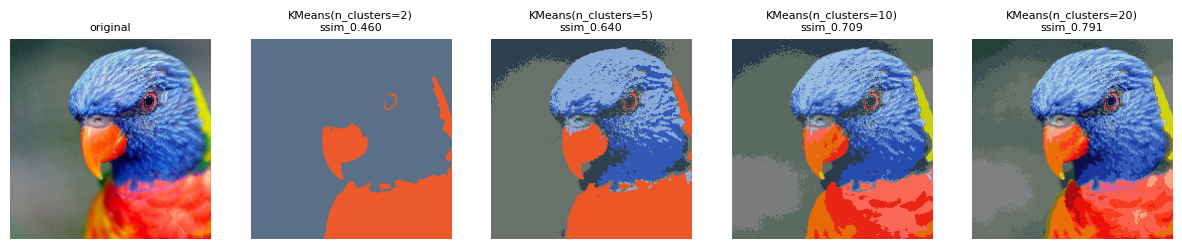

KMeans длительность 1.72 сек


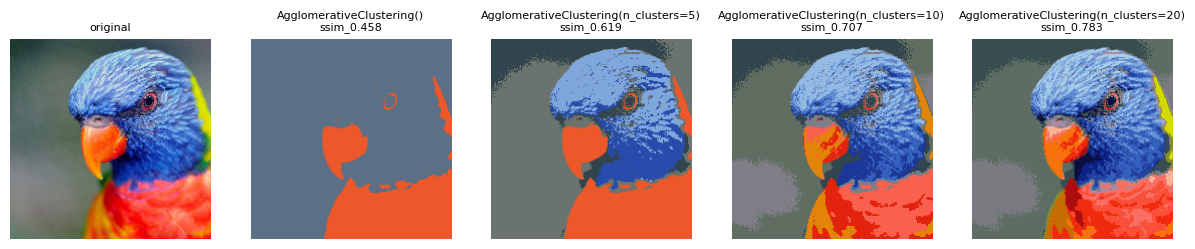

AgglomerativeClustering длительность 126.5 сек


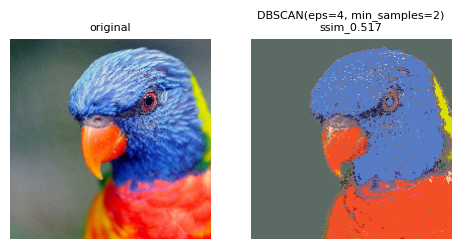

DBSCAN длительность 1.21 сек


In [12]:
start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, n_clusters in enumerate(K):
    fig.add_subplot(1, 5, i+1)
    get_image(img, KMeans, n_clusters=n_clusters)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("KMeans длительность "+ str(round((time.time() - start_time), 2)) + " сек")

start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, n_clusters in enumerate(K):
    fig.add_subplot(1, 5, i+1)
    get_image(img, AgglomerativeClustering, n_clusters=n_clusters)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("AgglomerativeClustering длительность "+ str(round((time.time() - start_time), 2)) + " сек")

start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, model in enumerate([None, DBSCAN]):
    fig.add_subplot(1, 5, i+1)
    get_image(img, model)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("DBSCAN длительность "+ str(round((time.time() - start_time), 2)) + " сек")

__В результате:__  
1. Для поставленной задачи `KMeans` самый лучший вариант. 
2. У `AgglomerativeClustering` метрика несколько хуже. К тому же от него виснет процессор и им можно обрабатывать картинки размерностью не более __180 x 180__ либо существенно сжимать исходные.
3. У `DBSCAN` нет параметра выбора количества кластеров, он создает много шума и по этому метрика самая низкая. Для картинок его лучше не использовать